# Machine Learning with Core ML
**By:** Joshua Newnham (Author)  
**Publisher:** [Packt Publishing](https://www.packtpub.com/)

# Chapter 4 - Emotion Detection with CNNs
 
## Core ML Model Conversion
In this notebook we tackle the Kaggle competition <a href='https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge'>Challenges in Representation Learning: Facial Expression Recognition Challenge</a> where we learn how to classify facial expressions from an image.

--- 

In [1]:
import keras 
keras.__version__

/Users/jnewnham/anaconda/envs/coreml27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.0.8'

In [2]:
import os
from matplotlib import pyplot as plt
import csv 
import random 
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('ggplot')

### Load Model and Weight 

In [3]:
from keras.models import model_from_json

In [4]:
# Load model architecture 
with open('output/fer2013_model_arc.json', 'r') as f:
    model_json = f.read() 
    model = model_from_json(model_json) 

In [5]:
# Load model weights 
model.load_weights("output/fer2013_model_weights.h5")

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1_conv2d (Conv2D)      (None, 48, 48, 64)        640       
_________________________________________________________________
layer_1_max (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
layer_2_conv2d (Conv2D)      (None, 24, 24, 128)       73856     
_________________________________________________________________
layer_2_max (MaxPooling2D)   (None, 12, 12, 128)       0         
_________________________________________________________________
layer_3_conv2d (Conv2D)      (None, 12, 12, 256)       295168    
_________________________________________________________________
layer_3_max (MaxPooling2D)   (None, 6, 6, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
__________

### Test model 

In [7]:
emotion_idx2label = [
    "Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"
]

In [8]:
def load_validation_data(file='data/fer2013/fer2013.csv'):
    val_labels = [] 
    val_images = []

    with open(file) as f:
        reader = csv.reader(f)
        _ = next(reader) # ignore the header 
        for row in reader:
            is_training = row[2].lower() == "training"
            emotion = int(row[0].replace("'", "")) 
            pixels = [float(pixel) for pixel in row[1].replace("'", "").split()]
        
            if not is_training:
                val_labels.append(emotion)
                val_images.append(pixels)                
            
    # Convert to a numpy
    val_x = np.array(val_images)
    
    # Normalize pixels 
    val_x = val_x.astype('float32')/255.0
    
    # Reshape into a 3D tensor 
    val_x = np.reshape(val_x, (-1, 48, 48, 1))
    
    # 
    classes = len(set(val_labels))
    val_y = [] 
    for label in val_labels:
        encoded_label = [0] * classes
        encoded_label[label] = 1 
        val_y.append(encoded_label)
    
    val_y = np.array(val_y, dtype='int')
    
    return val_x, val_y

In [9]:
val_x, val_y = load_validation_data()

Predicted Happy (actual Happy)


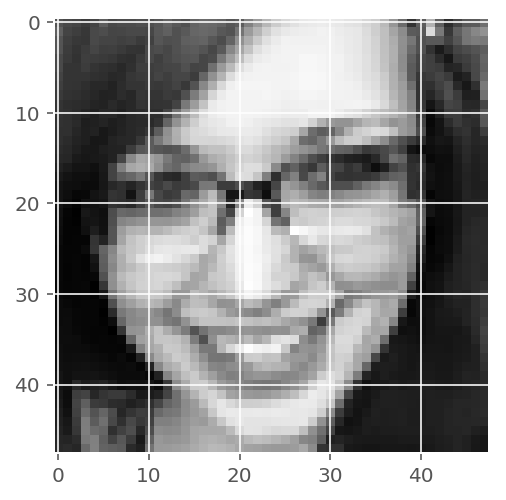

In [26]:
print("Predicted {} (actual {})".format(
    emotion_idx2label[np.argmax(val_y[4])], 
    emotion_idx2label[np.argmax(model.predict(val_x[4].reshape(1,48,48,1)))]))
plt.imshow(val_x[4].reshape(48,48), cmap='gray', interpolation='nearest')

Predicted Sad (actual Sad)


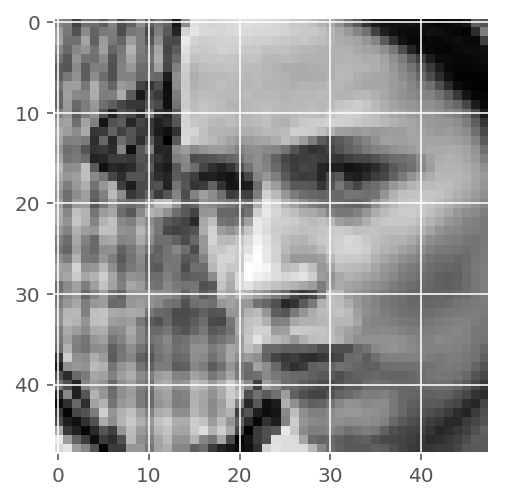

In [25]:
print("Predicted {} (actual {})".format(
    emotion_idx2label[np.argmax(val_y[12])], 
    emotion_idx2label[np.argmax(model.predict(val_x[12].reshape(1,48,48,1)))]))

plt.imshow(val_x[12].reshape(48,48), cmap='gray', interpolation='nearest')

### Create CoreML model

In [8]:
import coremltools

In [13]:
coreml_model = coremltools.converters.keras.convert(model, 
                                                    input_names=['image'], 
                                                    image_input_names=['image'], 
                                                    output_names=['classLabelProbs'],
                                                    class_labels=emotion_idx2label)

0 : layer_1_conv2d_input, <keras.engine.topology.InputLayer object at 0x11dc5b610>
1 : layer_1_conv2d, <keras.layers.convolutional.Conv2D object at 0x11dc5b650>
2 : layer_1_conv2d__activation__, <keras.layers.core.Activation object at 0x12e113690>
3 : layer_1_max, <keras.layers.pooling.MaxPooling2D object at 0x11dd00a90>
4 : layer_2_conv2d, <keras.layers.convolutional.Conv2D object at 0x11dc5bb50>
5 : layer_2_conv2d__activation__, <keras.layers.core.Activation object at 0x10a042b10>
6 : layer_2_max, <keras.layers.pooling.MaxPooling2D object at 0x11dc5b910>
7 : layer_3_conv2d, <keras.layers.convolutional.Conv2D object at 0x11dd55f50>
8 : layer_3_conv2d__activation__, <keras.layers.core.Activation object at 0x12e133110>
9 : layer_3_max, <keras.layers.pooling.MaxPooling2D object at 0x11dd75390>
10 : flatten_1, <keras.layers.core.Flatten object at 0x11dda9950>
11 : layer_4_dense, <keras.layers.core.Dense object at 0x11dd9afd0>
12 : layer_4_dense__activation__, <keras.layers.core.Activation

In [66]:
def predict(idx):
    from PIL import Image
    img = np.uint8(val_x[idx].reshape(48,48)*255)
    img = Image.fromarray(img).convert('L')  
    
    results = coreml_model.predict({'image':img})
    
    true_label = emotion_idx2label[np.argmax(val_y[idx])]
    
    predicted_label = results['classLabel']
    predicted_prob = results['classLabelProbs'][predicted_label]
    
    plt.imshow(val_x[idx].reshape(48,48), 
               cmap='gray', 
               interpolation='nearest')   
    plt.title("Pred: {} ({}%), Actual: {}".format(
        predicted_label, 
        int(predicted_prob*100),
        true_label))
    plt.tight_layout()
    plt.show()

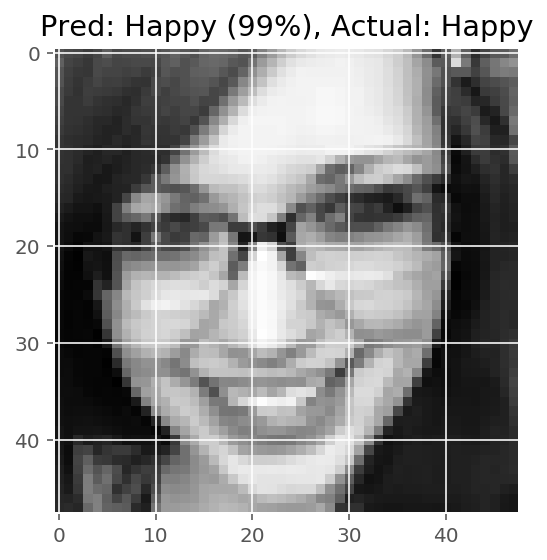

In [67]:
predict(4)

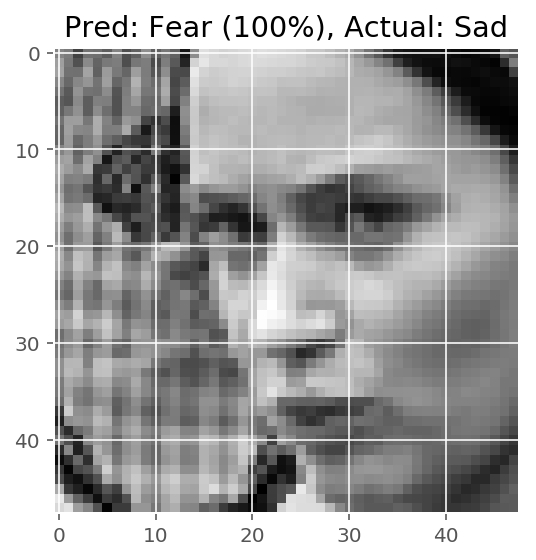

In [68]:
predict(12)

In [69]:
coreml_model.author = 'Joshua Newnham'
coreml_model.license = 'BSD'
coreml_model.short_description = '(Facial) expression recognition using CNN'
coreml_model.input_description['image'] = 'Input image; grayscale 48x48 of a face'
coreml_model.output_description['classLabelProbs'] = 'Probability of each expression'
coreml_model.output_description['classLabel'] = 'Most likely expression'

In [70]:
coreml_model.save('output/ExpressionRecognitionModel.mlmodel')

### Create CoreML model (using MLMultarray - non image) 

In [9]:
coreml_model = coremltools.converters.keras.convert(model, 
                                                    input_names=['image'], 
                                                    output_names=['classLabelProbs'],
                                                    class_labels=emotion_idx2label)

0 : layer_1_conv2d_input, <keras.engine.topology.InputLayer object at 0x11ef2f610>
1 : layer_1_conv2d, <keras.layers.convolutional.Conv2D object at 0x11ef2f650>
2 : layer_1_conv2d__activation__, <keras.layers.core.Activation object at 0x122fa6a10>
3 : layer_1_max, <keras.layers.pooling.MaxPooling2D object at 0x11efd2850>
4 : layer_2_conv2d, <keras.layers.convolutional.Conv2D object at 0x11ef2f810>
5 : layer_2_conv2d__activation__, <keras.layers.core.Activation object at 0x122fc9350>
6 : layer_2_max, <keras.layers.pooling.MaxPooling2D object at 0x11ef2fc10>
7 : layer_3_conv2d, <keras.layers.convolutional.Conv2D object at 0x11f029f50>
8 : layer_3_conv2d__activation__, <keras.layers.core.Activation object at 0x122fc9310>
9 : layer_3_max, <keras.layers.pooling.MaxPooling2D object at 0x11f049390>
10 : flatten_1, <keras.layers.core.Flatten object at 0x11f07d950>
11 : layer_4_dense, <keras.layers.core.Dense object at 0x11f06efd0>
12 : layer_4_dense__activation__, <keras.layers.core.Activation

In [10]:
coreml_model.author = 'Joshua Newnham'
coreml_model.license = 'BSD'
coreml_model.short_description = '(Facial) expression recognition using CNN'
coreml_model.input_description['image'] = 'Input image; grayscale 48x48 of a face'
coreml_model.output_description['classLabelProbs'] = 'Probability of each expression'
coreml_model.output_description['classLabel'] = 'Most likely expression'

In [11]:
coreml_model.save('output/ExpressionRecognitionModelB.mlmodel')